In [11]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np 

import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3

import warnings
warnings.filterwarnings("ignore")


### Step 0 of the Pre-processing: importing the data

In [12]:
df = pd.read_csv(".\Month_final\GHI_2016_2021.csv")
df.columns =['date', 'GHI']

In [13]:
df.shape

(17297280, 2)

In [18]:
df_year = df

### Step 1 of the Pre-processing: Cleaning the NaNs

In [19]:
df_year.isnull().sum()

date         0
GHI     717723
dtype: int64

In [20]:
def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))


In [27]:
df_year_na = df_year[df_year.GHI.isna()]
index_na_consec = np.array(df_year_na.index)
temp = ranges(index_na_consec)


In [28]:
temp = pd.DataFrame(temp)
temp.columns =["int1", "int2"]
temp[temp.int1 == temp.int2]

index_non_consec = temp[temp.int1 == temp.int2].int1.values


In [29]:
##Do the interpolation for the positions

index_na_consec_prev = index_non_consec-1
index_na_consec_next = index_non_consec+1

df_year.loc[index_non_consec, 'GHI'] = (df_year.loc[index_na_consec_prev,
                                                  'GHI'].values+df_year.loc[index_na_consec_next, 'GHI'].values)/2


In [30]:
#Drop the rest of the NaN

df_year = df_year.dropna()


In [31]:
df_year.isnull().sum()


date    0
GHI     0
dtype: int64

In [32]:
#Putting the index in the right format

#Formating the df with a datetime format

df_year['date'] = pd.to_datetime(df_year['date'])


#Setting date time as index

df_year = df_year.set_index("date", drop=True)

df_year.index.name = None

df_year


,GHI
2016-01-08 00:00:00,2.923
2016-01-08 00:00:10,2.957
2016-01-08 00:00:20,2.945
2016-01-08 00:00:30,2.938
2016-01-08 00:00:40,2.936
...,...
2021-11-02 23:59:10,2.717
2021-11-02 23:59:20,2.523
2021-11-02 23:59:30,2.495
2021-11-02 23:59:40,2.510


### Step 2 of the Pre-processing: Removal of outliers

In [33]:
## Removal of outliers
GHI_max = 1000
GHI_min = 0

df_year = df_year[df_year["GHI"] < GHI_max]
df_year = df_year[df_year["GHI"] > GHI_min]


### Step 3 of the Pre-processing: Calculation of the GHIcs

In [34]:
#Clear sky GHI calculation

latitude = 46.518
longitude = 6.565
time_zone = 'Europe/Zurich'
altitude = 400
place = 'Ecublens'
frequency = '10S'
limit_irr = 30

tus = Location(latitude, longitude, time_zone, altitude, place)

cs = tus.get_clearsky(df_year.index)
df_year['GHIcs'] = cs.ghi

df_year.head(5)


,GHI,GHIcs
2016-01-08 00:00:00,2.923,0.0
2016-01-08 00:00:10,2.957,0.0
2016-01-08 00:00:20,2.945,0.0
2016-01-08 00:00:30,2.938,0.0
2016-01-08 00:00:40,2.936,0.0


### Step 4 of the Pre-processing: Removal of the night measurements

In [35]:
#Filtering with GHIcs 
df_year = df_year[df_year["GHIcs"] > 30]


### Step 5 of the Pre-processing: Calculation of the kcs

In [36]:
#Calculating kcs

GHI = df_year["GHI"]
GHIcs = df_year["GHIcs"]
df_year.loc[:, "k"] = GHI / GHIcs
df_year.head(5)


,GHI,GHIcs,k
2016-01-08 07:59:00,15.394,30.209756,0.509570
2016-01-08 07:59:10,15.447,30.471824,0.506927
2016-01-08 07:59:20,15.472,30.734662,0.503406
2016-01-08 07:59:30,15.542,30.998266,0.501383
2016-01-08 07:59:40,15.539,31.262629,0.497047


### Step 6 of the Pre-processing: Calculation of the 1st, 2nd and 3rd order derivatives

In [38]:
def FirstOrderCentraldDiff (serie, h):
    y_t0 = serie.values.flatten()[:-1]
    y_t1 = serie.values.flatten()[1:]
    return np.concatenate([(y_t0-y_t1)/(h), [np.nan]])

def SecondOrderCentralDiff (serie, h):
    y_t0 = serie.values.flatten()[:-2]
    y_t1 = serie.values.flatten()[1:-1]
    y_t2 = serie.values.flatten()[2:]
    return np.concatenate([(y_t0-2*y_t1+y_t2)/((h)**2), [np.nan], [np.nan]])
    
def ThirdOrderCentralDiff(serie, h):
    y_t0 = serie.values.flatten()[:-3]
    y_t1 = serie.values.flatten()[1:-2]
    y_t2 = serie.values.flatten()[2:-1]
    y_t3 = serie.values.flatten()[3:]
    return np.concatenate([(y_t0-3*y_t1+3*y_t2-y_t3)/(h**3), [np.nan], [np.nan], [np.nan]])


In [44]:
h = 10 #10s

df_year["GHI_d1"] = FirstOrderCentraldDiff(df_year.GHI, h)
df_year["GHIcs_d1"] = FirstOrderCentraldDiff(df_year.GHIcs, h)
df_year["k_d1"] = FirstOrderCentraldDiff(df_year.k, h)


df_year["GHI_d2"] = SecondOrderCentralDiff(df_year.GHI, h)
df_year["GHIcs_d2"] = SecondOrderCentralDiff(df_year.GHIcs, h)
df_year["k_d2"] = SecondOrderCentralDiff(df_year.k, h)

df_year["GHI_d3"] = ThirdOrderCentralDiff(df_year.GHI, h)
df_year["GHIcs_d3"] = ThirdOrderCentralDiff(df_year.GHIcs, h)
df_year["k_d3"] = ThirdOrderCentralDiff(df_year.k, h)

df_year = df_year.dropna()


In [45]:
df_year.columns

Index(['GHI', 'GHIcs', 'k', 'GHI_d1', 'GHI_d2', 'GHI_d3', 'GHIcs_d1',
       'GHIcs_d2', 'GHIcs_d3', 'k_d1', 'k_d2', 'k_d3', 'month', 'day', 'hour'],
      dtype='object')

### Step 7 of the Pre-processing: Adding the cycle indicators (second, hours, day and month numbers)

In [46]:
def norm_sin_hour(x):
    return np.sin(x*np.pi/24)

def norm_sin_day(x):
    return np.sin(x*np.pi/365)

def norm_sin_month(x):
    return np.sin(x*np.pi/12)


df_year.loc[:, "month"] = norm_sin_month(
    df_year.index.month).copy()

df_year.loc[:, "day"] = norm_sin_day(
    df_year.index.dayofyear).copy()

df_year.loc[:, "hour"] = norm_sin_hour(
    df_year.index.hour).copy()

df_year.head(5)


,GHI,GHIcs,k,GHI_d1,GHI_d2,GHI_d3,GHIcs_d1,GHIcs_d2,GHIcs_d3,k_d1,k_d2,k_d3,month,day,hour
2016-01-08 07:59:00,15.394,30.209756,0.509570,-0.0053,-0.00028,-0.000073,-0.026207,0.000008,4.696792e-09,0.000264,-0.000009,-2.377658e-06,0.258819,0.068802,0.793353
2016-01-08 07:59:10,15.447,30.471824,0.506927,-0.0025,0.00045,0.000118,-0.026284,0.000008,7.848464e-09,0.000352,0.000015,3.812120e-06,0.258819,0.068802,0.793353
2016-01-08 07:59:20,15.472,30.734662,0.503406,-0.0070,-0.00073,-0.000106,-0.026360,0.000008,4.653756e-09,0.000202,-0.000023,-3.420689e-06,0.258819,0.068802,0.793353
2016-01-08 07:59:30,15.542,30.998266,0.501383,0.0003,0.00033,-0.000012,-0.026436,0.000008,4.618456e-09,0.000434,0.000011,-3.500268e-07,0.258819,0.068802,0.793353
2016-01-08 07:59:40,15.539,31.262629,0.497047,-0.0030,0.00045,0.000087,-0.026512,0.000007,7.796691e-09,0.000323,0.000015,2.749664e-06,0.258819,0.068802,0.793353


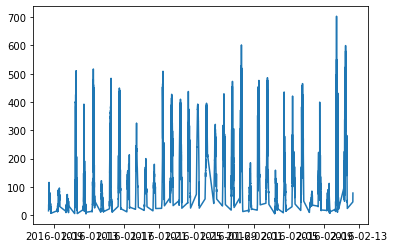

In [47]:
plt.plot(df_year.GHI[0:100000])


### Step 8 of the Pre-processing: Sampling and exporting the data

In [49]:
sampling_frequencies = ["10s", "1T", "5T", "10T", "15T",
                        "30T", "45T", "1H", "2H", "4H", "6H", "12H", "24H", "48H", "72H", "4D", "5D", "6D", "7D"]
sampling_frequencies_eng = ["10s", "1mn", "5mn", "10mn", "15mn",
                            "30mn", "45mn", "1h", "2h", "4h", "6h", "12h", "24h", "48h", "72h", "4days", "5days", "6days", "7days"]
for i, frequency in enumerate(sampling_frequencies):
    save_path_cs = 'Big_data_cleaned_sampled/Data_sampled_' + \
        sampling_frequencies_eng[i] + '.csv'
    temp_sampled = df_year.resample(frequency).mean()
    temp_sampled = temp_sampled.dropna()
    temp_sampled.to_csv(save_path_cs)


In [ ]:
df_2= pd.read_csv(".\Big_data_cleaned_sampled\Data_sampled_15mn.csv")


In [ ]:
df_2.columns

Index(['Unnamed: 0', 'GHI', 'GHIcs', 'k', 'GHI_d1', 'GHI_d2', 'GHI_d3',
       'GHIcs_d1', 'GHIcs_d2', 'GHIcs_d3', 'k_d1', 'k_d2', 'k_d3', 'month',
       'day', 'hour'],
      dtype='object')

In [ ]:
sampling_frequencies = ["1H", "2H", "4H", "6H", "12H","24H", "48H", "72H", "4D", "5D", "6D", "7D"]
sampling_frequencies_eng = ["1h", "2h", "4h", "6h", "12h", "24h", "48h", "72h", "4days", "5days", "6days", "7days"]
